## <span style="color:darkblue; font-weight:bold"> A. Setups </span>

In [271]:
import os
print(os.getcwd())
os.chdir('C:/Users/ADMIN/Desktop/act61-mfe-prediction-competition')

C:\Users\ADMIN\Desktop\act61-mfe-prediction-competition


In [272]:
#Import modules=================================================================================================================
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [273]:
#Setup some visual properties=================================================================================================================
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = "Tahoma"
%matplotlib inline

In [274]:
#Read files=====================================================================================================================
train = pd.read_csv("train.csv", sep=";")
print(train.info())

test = pd.read_csv("test.csv", sep=";")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6000 non-null   object 
 1   year           6000 non-null   int64  
 2   selling_price  6000 non-null   int64  
 3   km_driven      6000 non-null   int64  
 4   fuel           6000 non-null   object 
 5   seller_type    6000 non-null   object 
 6   transmission   6000 non-null   object 
 7   owner          6000 non-null   object 
 8   mileage        5841 non-null   object 
 9   engine         5841 non-null   object 
 10  max_power      5846 non-null   object 
 11  torque         5840 non-null   object 
 12  seats          5841 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 609.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------   

## <span style="color:darkblue; font-weight:bold"> B. Functions </span>

In [275]:
%run Helper_Functions.ipynb

## <span style="color:darkblue; font-weight:bold"> C. Cleaning training set </span>

## <span style="color:orange; font-weight:bold"> name </span>

__1.__ Extracting brand

In [276]:
train.name

0                             Tata Nexon 1.5 Revotorq XM
1                           Hyundai i20 Active SX Diesel
2                                 Toyota Fortuner 4x2 AT
3                              Hyundai Verna 1.6 VTVT SX
4                         Volvo XC40 D4 Inscription BSIV
                              ...                       
5995                                   Maruti A-Star Lxi
5996                              Maruti Wagon R LXI CNG
5997                          Tata Tigor 1.2 Revotron XT
5998    Mahindra Bolero 2011-2019 DI NON AC BS III White
5999                               Honda Amaze SX i-DTEC
Name: name, Length: 6000, dtype: object

In [277]:
train["brand"] = pd.Series([Extract_brand(x) for x in train.name])

## <span style="color:orange; font-weight:bold"> mileage </span>

__1.__ Convert to numeric
<br>__2.__ Convert into same metric

In [278]:
print(type(train["mileage"][0]))
print("Number of levels:", len(train["mileage"].unique()))
print("Number of NAs:",  train["mileage"].isna().sum())
print("Percentage of NAs:", train["mileage"].isna().sum()/6000)
train["mileage"]

<class 'str'>
Number of levels: 372
Number of NAs: 159
Percentage of NAs: 0.0265


0        21.5 kmpl
1       21.19 kmpl
2       12.55 kmpl
3       17.01 kmpl
4        18.0 kmpl
           ...    
5995     19.0 kmpl
5996    26.6 km/kg
5997     20.3 kmpl
5998    15.96 kmpl
5999     25.8 kmpl
Name: mileage, Length: 6000, dtype: object

In [279]:
print("***Split value and unit")
mileage = train["mileage"].copy()

mileage_val = mileage.transform(SplitValue)
mileage_unit = mileage.transform(SplitUnit)

***Split value and unit


In [280]:
mileage_unit.unique()

array(['kmpl', <NA>, 'km/kg'], dtype=object)

In [281]:
print("***Convert mileage to numeric:")
mileage_val = mileage_val.transform(lambda x: float(x) if pd.isna(x)==False else np.NaN)

***Convert mileage to numeric:


In [282]:
print(mileage_val[pd.isna(mileage_unit) == True].unique()) #Comment: All unit-missing mileage has value missing
                                                           #         (which means all available mileage dont have their unit missing)

[nan]



***Visual inspection:
      mileage    fuel
0       21.50  Diesel
1       21.19  Diesel
2       12.55  Diesel
3       17.01  Petrol
4       18.00  Diesel
...       ...     ...
5994    26.00  Diesel
5995    19.00  Petrol
5997    20.30  Petrol
5998    15.96  Diesel
5999    25.80  Diesel

[5774 rows x 2 columns]


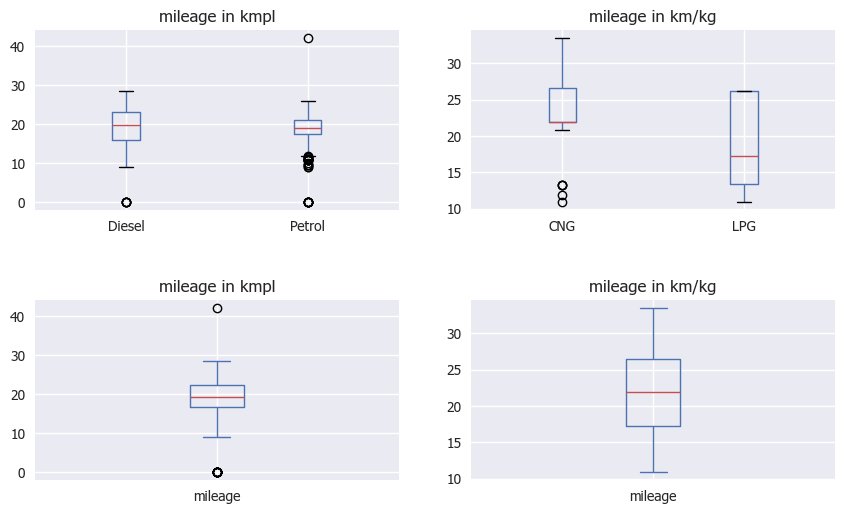

In [283]:
print("\n***Visual inspection:")
fig, ((ax, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize=(10,6))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

mileage_val_kmpl = pd.concat([ mileage_val[mileage_unit == "kmpl"], train.loc[mileage_unit == "kmpl", "fuel"] ], axis=1)
mileage_val_kmpl.boxplot(by="fuel", ax=ax)
ax.set_title("mileage in kmpl")
ax.set_xlabel("")

mileage_val_kmkg = pd.concat([ mileage_val[mileage_unit == "km/kg"], train.loc[mileage_unit == "km/kg", "fuel"] ], axis=1)
mileage_val_kmkg.boxplot(by="fuel", ax=ax1)
ax1.set_title("mileage in km/kg")
ax1.set_xlabel("")

mileage_val_kmpl["mileage"].plot(kind="box", ax=ax2)
ax2.set_title("mileage in kmpl")

mileage_val_kmkg["mileage"].plot(kind="box", ax=ax3)
ax3.set_title("mileage in km/kg")

fig.suptitle("")
plt.show(); plt.close("all")

In [284]:
print("***Investigating outliers:")
print("**Value = 0")
location = mileage_val[mileage_val == 0].index
train.iloc[location].pipe(print)

print("**Extremely high values")
location = mileage_val[mileage_val >=40].index
train.iloc[location]

***Investigating outliers:
**Value = 0
                                                   name  year  selling_price  \
343                      Mahindra Bolero Pik-Up FB 1.7T  2020         679000   
721                              Hyundai Santro Xing GL  2009         120000   
763                     Land Rover Freelander 2 TD4 HSE  2013        1650000   
1266  Tata Indica Vista Aura Safire Anniversary Edition  2009         135000   
1883                Mercedes-Benz M-Class ML 350 4Matic  2011        1700000   
2068                       Hyundai Santro Xing (Non-AC)  2010         110000   
2499                             Hyundai Santro Xing GL  2011         150000   
2884                    Mahindra Bolero Pik-Up CBC 1.7T  2019         722000   
4224                             Hyundai Santro Xing GL  2008         105000   
4270                             Hyundai Santro Xing GL  2010         150000   
5376                       Hyundai Santro Xing (Non-AC)  2013         184000   
5

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand
5537,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.0 kmpl,1969 CC,400 bhp,640Nm@ 1740rpm,4.0,Volvo


In [285]:
print("***Convert mileage_val = 0 to NaN")
for i in range(len(mileage_val)):
    if (pd.isna(mileage_val[i])==False) & (mileage_val[i]==0):
        mileage_val[i] = np.NaN

***Convert mileage_val = 0 to NaN


In [286]:
print("***Covert into km/kg:")
print("Formula: km/kg = kmpl / density")
fuel = train["fuel"].copy()
density = fuel.transform(Density)

for i in range(len(mileage_val)):
    if (pd.isna(mileage_unit[i])==False) & (mileage_unit[i] == "kmpl"):
        mileage_unit[i] = "km/kg"
        mileage_val[i] = mileage_val[i] / density[i]

mileage_val.info()
mileage_unit.unique()

***Covert into km/kg:
Formula: km/kg = kmpl / density
<class 'pandas.core.series.Series'>
RangeIndex: 6000 entries, 0 to 5999
Series name: mileage
Non-Null Count  Dtype  
--------------  -----  
5828 non-null   float64
dtypes: float64(1)
memory usage: 47.0 KB


array(['km/kg', <NA>], dtype=object)

In [287]:
train["mileage"] = mileage_val

## <span style="color:orange; font-weight:bold"> engine </span>
__1.__ Convert to numeric

In [288]:
print(type(train["engine"][0]))
print("Number of levels:", len(train["engine"].unique()))
print("Percentage of NAs:", train["engine"].isna().sum()/6000)
train["engine"]

<class 'str'>
Number of levels: 119
Percentage of NAs: 0.0265


0       1497 CC
1       1396 CC
2       2982 CC
3       1591 CC
4       1969 CC
         ...   
5995     998 CC
5996     998 CC
5997    1199 CC
5998    2523 CC
5999    1498 CC
Name: engine, Length: 6000, dtype: object

In [289]:
print("***Split value and unit:")
engine = train["engine"].copy()

engine_val = engine.transform(SplitValue)
engine_unit = engine.transform(SplitUnit)

engine_unit.unique()

***Split value and unit:


array(['CC', <NA>], dtype=object)

In [290]:
print("***Convert engine to numeric:")
engine_val = engine_val.transform(lambda x: float(x) if pd.isna(x)==False else np.NaN)
engine_val.info()

***Convert engine to numeric:
<class 'pandas.core.series.Series'>
RangeIndex: 6000 entries, 0 to 5999
Series name: engine
Non-Null Count  Dtype  
--------------  -----  
5841 non-null   float64
dtypes: float64(1)
memory usage: 47.0 KB


***Visual inspection:


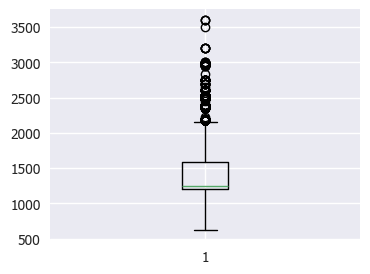

**Investigating outliers :


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand
733,Ford Endeavour 3.2 Titanium AT 4X4,2018,3250000,12000,Diesel,Individual,Automatic,First Owner,13.144578,3198 CC,197 bhp,470Nm@ 1750-2500rpm,7.0,Ford
1287,Ford Endeavour 3.2 Titanium AT 4X4,2018,3200000,35000,Diesel,Individual,Automatic,First Owner,13.144578,3198 CC,197 bhp,470Nm@ 1750-2500rpm,7.0,Ford
1426,Ford Endeavour 3.2 Titanium AT 4X4,2018,3250000,12000,Diesel,Individual,Automatic,First Owner,13.144578,3198 CC,197 bhp,470Nm@ 1750-2500rpm,7.0,Ford
2630,Ford Endeavour 3.2 Titanium AT 4X4,2016,2100000,80000,Diesel,Individual,Automatic,First Owner,13.144578,3198 CC,197 bhp,470Nm@ 1750-2500rpm,7.0,Ford
2918,Ford Endeavour 3.2 Titanium AT 4X4,2016,2280000,120000,Diesel,Individual,Automatic,Second Owner,13.144578,3198 CC,197 bhp,470Nm@ 1750-2500rpm,7.0,Ford
256,Mercedes-Benz E-Class E350 Petrol,2009,1000000,80000,Petrol,Individual,Automatic,Third Owner,14.770270,3498 CC,272 bhp,355Nm@ 4500rpm,5.0,Mercedes-Benz
1510,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,12.837838,3604 CC,280 bhp,347Nm@ 4300rpm,5.0,Jeep
4882,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,12.837838,3604 CC,280 bhp,347Nm@ 4300rpm,5.0,Jeep
5686,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,12.837838,3604 CC,280 bhp,347Nm@ 4300rpm,5.0,Jeep


In [291]:
print("***Visual inspection:")
fig, ax = plt.subplots(figsize=(4,3))
ax.boxplot(x = engine_val.dropna())

plt.show(); plt.close("all")

print("**Investigating outliers :")
location = engine_val[engine_val > 3000].sort_values().index
train.iloc[location]

In [292]:
train["engine"] = engine_val

## <span style="color:orange; font-weight:bold"> Part 10: max_power </span>
__1.__ Convert to numeric

In [293]:
print(type(train["max_power"][0]))
print("Number of levels:", len(train["max_power"].unique()))
print("Percentage of NAs:", train["max_power"].isna().sum()/6000)
train["max_power"].sort_values()

<class 'str'>
Number of levels: 304
Percentage of NAs: 0.025666666666666667


4681     bhp
5131       0
3013       0
930        0
2629       0
        ... 
5704     NaN
5810     NaN
5881     NaN
5903     NaN
5913     NaN
Name: max_power, Length: 6000, dtype: object

In [294]:
print("***Split value and unit:")
max_power = train["max_power"].copy()

max_power_val = max_power.transform(SplitValue)
max_power_unit = max_power.transform(SplitUnit)

max_power_unit.unique()

***Split value and unit:


array(['bhp', <NA>], dtype=object)

In [295]:
print("***Convert max_power to numeric:")
max_power_val = max_power_val.transform(lambda x: np.NaN if (pd.isna(x)==False) & (x=="bhp") else x).transform(lambda x: float(x) if pd.isna(x)==False else np.NaN)
max_power_val.info()

***Convert max_power to numeric:
<class 'pandas.core.series.Series'>
RangeIndex: 6000 entries, 0 to 5999
Series name: max_power
Non-Null Count  Dtype  
--------------  -----  
5845 non-null   float64
dtypes: float64(1)
memory usage: 47.0 KB


***Visual inspection:


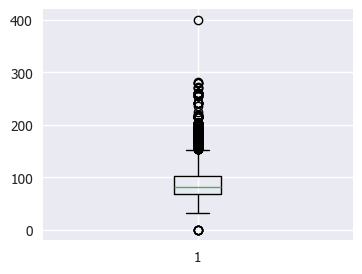

**Investigating outliers :
                                 name  year  selling_price  km_driven    fuel  \
930   Maruti Swift Dzire VDI Optional  2017         589000      41232  Diesel   
2213              Maruti Alto K10 LXI  2011         204999      97500  Petrol   
2629              Maruti Alto K10 LXI  2011         204999      97500  Petrol   
3013   Tata Indica Vista Quadrajet LS  2012         240000      70000  Diesel   
5131  Maruti Swift Dzire VDI Optional  2017         589000      41232  Diesel   

     seller_type transmission        owner  mileage  engine max_power torque  \
930       Dealer       Manual  First Owner      NaN     NaN         0    NaN   
2213  Individual       Manual  First Owner      NaN     NaN         0    NaN   
2629  Individual       Manual  First Owner      NaN     NaN         0    NaN   
3013  Individual       Manual  First Owner      NaN     NaN         0    NaN   
5131      Dealer       Manual  First Owner      NaN     NaN         0    NaN   

     

In [296]:
print("***Visual inspection:")
fig, ax = plt.subplots(figsize=(4,3))
ax.boxplot(x = max_power_val.dropna())

plt.show(); plt.close("all")

print("**Investigating outliers :")
location = max_power_val[max_power_val == 0].index
train.iloc[location].pipe(print)

In [297]:
print("***Convert 0 max_power to np.NaN")
for i, val in enumerate(max_power_val):
    if val==0:
        max_power_val[i] = np.NaN

***Convert 0 max_power to np.NaN


In [298]:
train["max_power"] = max_power_val

## <span style="color:orange; font-weight:bold"> torque </span>
__1.__ Extract the 1st number

In [299]:
print(type(train["torque"][0]))
print("Number of levels:", len(train["torque"].unique()))
print("Percentage of NAs:", train["torque"].isna().sum()/6000)
train["torque"]

<class 'str'>
Number of levels: 414
Percentage of NAs: 0.02666666666666667


0          260Nm@ 1500-2750rpm
1       219.66nm@ 1500-2750rpm
2          360Nm@ 1400-3200rpm
3             154.9Nm@ 4200rpm
4                        400Nm
                 ...          
5995             90Nm@ 3500rpm
5996             77Nm@ 3500rpm
5997            114Nm@ 3500rpm
5998       180Nm@ 1440-1500rpm
5999            200Nm@ 1750rpm
Name: torque, Length: 6000, dtype: object

In [300]:
print("***Split value and unit:")
torque = train["torque"].copy()

torque_val = torque.transform(TorqueVal)
torque_unit = torque.transform(TorqueUnit)

print(torque_unit.unique())

***Split value and unit:
['nm' <NA> 'kgm']


In [301]:
print("\n***Convert to numeric:")
torque_val = torque_val.transform(lambda x: float(x) if pd.isna(x)==False else np.NaN)
torque_val.info()


***Convert to numeric:
<class 'pandas.core.series.Series'>
RangeIndex: 6000 entries, 0 to 5999
Series name: torque
Non-Null Count  Dtype  
--------------  -----  
5840 non-null   float64
dtypes: float64(1)
memory usage: 47.0 KB


***Visual inspection:


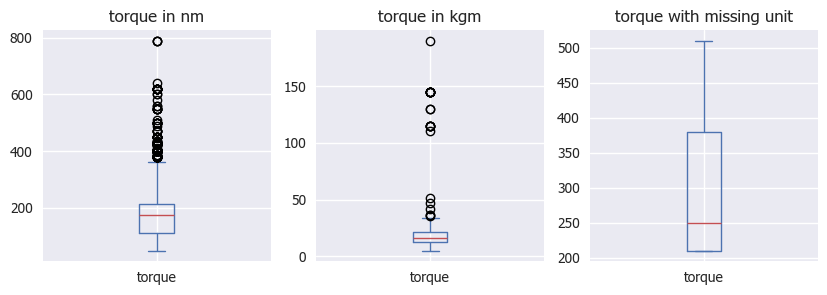


**Investigating outliers in nm:
              name          torque  engine    mileage  selling_price
1201  Maruti Zen D  789Nm@ 2250rpm  1527.0  25.060241          80000
5767  Maruti Zen D  789Nm@ 2250rpm  1527.0  25.060241          85000
5865  Maruti Zen D  789Nm@ 2250rpm  1527.0  25.060241         120000

**Investigating outliers in kgm:
                                   name                     torque  engine  \
4979                  BMW 5 Series 530d  51@ 1,750-3,000(kgm@ rpm)  2993.0   
4643      Mahindra Logan Petrol 1.4 GLE       110@ 3,000(kgm@ rpm)  1390.0   
2633        Tata Sumo EX 10/7 Str BSIII       115@ 2,500(kgm@ rpm)  1948.0   
603             Tata Sumo GX 7 Str BSII        115@ 2500(kgm@ rpm)  1948.0   
1269              Tata Sumo CX 9 Seater       115@ 2,500(kgm@ rpm)  1948.0   
3149        Tata Sumo EX 10/7 Str BSIII       115@ 2,500(kgm@ rpm)  1948.0   
2093              Tata Sumo CX 9 Seater       115@ 2,500(kgm@ rpm)  1948.0   
330               Ford Ikon 1.6 E

In [302]:
print("***Visual inspection:")
fig, (ax, ax1, ax2) = plt.subplots(1,3,figsize=(10,3))

torque_val[torque_unit == "nm"].plot(kind="box", ax=ax)
ax.set_title("torque in nm")

torque_val[torque_unit == "kgm"].plot(kind="box", ax=ax1)
ax1.set_title("torque in kgm")

torque_val[pd.isna(torque_unit) == True].plot(kind="box", ax=ax2)
ax2.set_title("torque with missing unit")

plt.show()
plt.close("all")

print("\n**Investigating outliers in nm:")
location = torque_val[(torque_val > 700) & (torque_unit=="nm")].sort_values().index
print(train[["name", "torque", "engine", "mileage", "selling_price"]].iloc[location]) #Comment: Nothing errornous here
 

print("\n**Investigating outliers in kgm:")
location = torque_val[(torque_val > 50) & (torque_unit=="kgm")].sort_values().index
train[["name", "torque", "engine", "mileage", "selling_price"]].iloc[location].pipe(print)


print("\n**Investigating torque with missing units:")
location = torque_val[pd.isna(torque_unit) == True].dropna().sort_values().index
train[["name", "torque", "engine", "mileage", "selling_price"]].iloc[location].pipe(print)

In [303]:
print("***Convert all missing unit obs to nm:")
for i in range(len(torque_val)):
    if pd.isna(torque_unit[i])==True:
        torque_unit[i] = "nm"

print("\n**With torque in nm: Change torque_val of 4 obs")
torque_val[[1201, 5767, 5865]] = 96

print("\n**With torque in kgm: Change torque_unit of all obs >= 100")
for i in range(len(torque_val)):
    if( (pd.isna(torque_val[i])==False) & (pd.isna(torque_unit[i])==False) & (torque_unit[i]=="kgm") & (torque_val[i]>=100)):
        torque_unit[i] = "nm"

***Convert all missing unit obs to nm:

**With torque in nm: Change torque_val of 4 obs

**With torque in kgm: Change torque_unit of all obs >= 100


In [304]:
print("***Convert to nm:")

for i in range(len(torque_val)):
    if torque_unit[i] == "kgm":
        torque_unit[i] = "nm"
        torque_val[i] = torque_val[i]/0.102
        
torque_val.info()
torque_unit.unique()

***Convert to nm:
<class 'pandas.core.series.Series'>
RangeIndex: 6000 entries, 0 to 5999
Series name: torque
Non-Null Count  Dtype  
--------------  -----  
5840 non-null   float64
dtypes: float64(1)
memory usage: 47.0 KB


array(['nm'], dtype=object)

In [305]:
train["torque"] = torque_val

## <span style="color:darkblue; font-weight:bold"> D. Cleaning test set </span>

## <span style="color:orange; font-weight:bold"> name </span>

__1.__ Extracting brand

In [306]:
test["brand"] = pd.Series([Extract_brand(x) for x in test.name])

## <span style="color:orange; font-weight:bold"> mileage </span>

__1.__ Convert to numeric
<br>__2.__ Convert into same metric

In [307]:
test["mileage"]

0        14.3 kmpl
1        17.8 kmpl
2        19.1 kmpl
3       12.05 kmpl
4        21.7 kmpl
           ...    
2123     20.7 kmpl
2124     28.4 kmpl
2125    17.88 kmpl
2126    19.67 kmpl
2127    21.21 kmpl
Name: mileage, Length: 2128, dtype: object

In [308]:
print("***Split value and unit:")
mileage = test["mileage"].copy()

mileage_val = mileage.transform(SplitValue)
mileage_unit = mileage.transform(SplitUnit)
mileage_unit.unique()

***Split value and unit:


array(['kmpl', <NA>, 'km/kg'], dtype=object)

***Convert mileage to numeric:
<class 'pandas.core.series.Series'>
RangeIndex: 2128 entries, 0 to 2127
Series name: mileage
Non-Null Count  Dtype  
--------------  -----  
2066 non-null   float64
dtypes: float64(1)
memory usage: 16.8 KB

***Visual inspection:


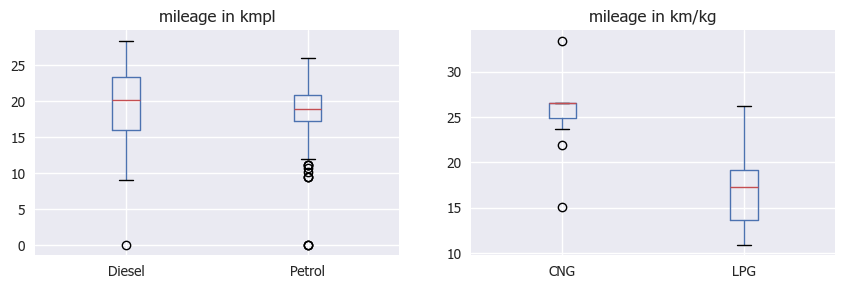

[nan]


In [309]:
print("***Convert mileage to numeric:")
mileage_val = mileage_val.transform(lambda x: float(x) if pd.isna(x)==False else np.NaN)
mileage_val.info()

print("\n***Visual inspection:")
fig, (ax, ax1) = plt.subplots(1,2,figsize=(10,3))

mileage_val_kmpl = pd.concat([ mileage_val[mileage_unit == "kmpl"], test.loc[mileage_unit == "kmpl", "fuel"] ], axis=1)
mileage_val_kmpl.boxplot(by="fuel", ax=ax)
ax.set_title("mileage in kmpl")
ax.set_xlabel("")

mileage_val_kmkg = pd.concat([ mileage_val[mileage_unit == "km/kg"], test.loc[mileage_unit == "km/kg", "fuel"] ], axis=1)
mileage_val_kmkg.boxplot(by="fuel", ax=ax1)
ax1.set_title("mileage in km/kg")
ax1.set_xlabel("")

fig.suptitle("")
plt.show(); plt.close("all")      


print(mileage_val[pd.isna(mileage_unit) == True].unique())

In [310]:
print("***Covert into km/kg:")
print("Formula: km/kg = kmpl / density")
fuel = test["fuel"].copy()
density = fuel.transform(Density)

for i in range(len(mileage_val)):
    if (pd.isna(mileage_unit[i])==False) & (mileage_unit[i] == "kmpl"):
        mileage_unit[i] = "km/kg"
        mileage_val[i] = mileage_val[i] / density[i]

mileage_val.info()
mileage_unit.unique()

***Covert into km/kg:
Formula: km/kg = kmpl / density
<class 'pandas.core.series.Series'>
RangeIndex: 2128 entries, 0 to 2127
Series name: mileage
Non-Null Count  Dtype  
--------------  -----  
2066 non-null   float64
dtypes: float64(1)
memory usage: 16.8 KB


array(['km/kg', <NA>], dtype=object)

In [311]:
test["mileage"] = mileage_val

## <span style="color:orange; font-weight:bold"> Part 9: engine </span>
__1.__ Convert to numeric

In [312]:
print(type(test["engine"][0]))
print("Number of levels:", len(test["engine"].unique()))
print("Percentage of NAs:", test["engine"].isna().sum()/6000)
test["engine"]

<class 'str'>
Number of levels: 96
Percentage of NAs: 0.010333333333333333


0       1598 CC
1       1497 CC
2       1197 CC
3       2179 CC
4       1498 CC
         ...   
2123    1197 CC
2124    1248 CC
2125    1396 CC
2126    1582 CC
2127    1197 CC
Name: engine, Length: 2128, dtype: object

In [313]:
print("***Split value and unit:")
engine = test["engine"].copy()

engine_val = engine.transform(SplitValue)
engine_unit = engine.transform(SplitUnit)
engine_unit.unique()

***Split value and unit:


array(['CC', <NA>], dtype=object)

In [314]:
print("***Convert engine to numeric:")
engine_val = engine_val.transform(lambda x: float(x) if pd.isna(x)==False else np.NaN)
engine_val.info()

***Convert engine to numeric:
<class 'pandas.core.series.Series'>
RangeIndex: 2128 entries, 0 to 2127
Series name: engine
Non-Null Count  Dtype  
--------------  -----  
2066 non-null   float64
dtypes: float64(1)
memory usage: 16.8 KB


***Visual inspection:


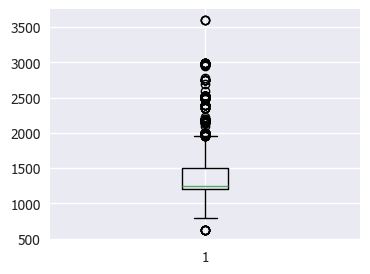

**Investigating outliers :


,id,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand
600,601,Jeep Wrangler 2016-2019 3.6 4X4,2017,17000,Petrol,Individual,Automatic,First Owner,12.837838,3604 CC,280 bhp,347Nm@ 4300rpm,5.0,Jeep
1073,1074,Jeep Wrangler 2016-2019 3.6 4X4,2017,17000,Petrol,Individual,Automatic,First Owner,12.837838,3604 CC,280 bhp,347Nm@ 4300rpm,5.0,Jeep
1880,1881,Jeep Wrangler 2016-2019 3.6 4X4,2017,17000,Petrol,Individual,Automatic,First Owner,12.837838,3604 CC,280 bhp,347Nm@ 4300rpm,5.0,Jeep


In [315]:
print("***Visual inspection:")
fig, ax = plt.subplots(figsize=(4,3))
ax.boxplot(x = engine_val.dropna())

plt.show(); plt.close("all")

print("**Investigating outliers :")
location = engine_val[engine_val > 3000].sort_values().index
test.iloc[location]

In [316]:
test["engine"] = engine_val

## <span style="color:orange; font-weight:bold"> max_power </span>
__1.__ Convert to numeric

In [317]:
print(type(test["max_power"][0]))
print("Number of levels:", len(test["max_power"].unique()))
print("Percentage of NAs:", test["max_power"].isna().sum()/6000)
test["max_power"]

<class 'str'>
Number of levels: 237
Percentage of NAs: 0.010166666666666666


0       103.5 bhp
1       117.3 bhp
2          82 bhp
3         120 bhp
4       98.96 bhp
          ...    
2123    81.86 bhp
2124    74.02 bhp
2125     52.8 bhp
2126    126.2 bhp
2127    81.80 bhp
Name: max_power, Length: 2128, dtype: object

In [318]:
print("***Split value and unit:")
max_power = test["max_power"].copy()

max_power_val = max_power.transform(SplitValue)
max_power_unit = max_power.transform(SplitUnit)
max_power_unit.unique()

***Split value and unit:


array(['bhp', <NA>], dtype=object)

In [319]:
print("***Convert max_power to numeric:")
max_power_val = max_power_val.transform(lambda x: np.NaN if (pd.isna(x)==False) & (x=="bhp") else x).transform(lambda x: float(x) if pd.isna(x)==False else np.NaN)
max_power_val.info()

***Convert max_power to numeric:
<class 'pandas.core.series.Series'>
RangeIndex: 2128 entries, 0 to 2127
Series name: max_power
Non-Null Count  Dtype  
--------------  -----  
2067 non-null   float64
dtypes: float64(1)
memory usage: 16.8 KB


***Visual inspection:


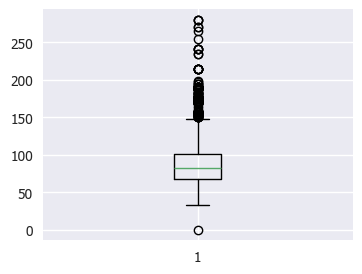

**Investigating outliers (value = 0):
        id                            name  year  km_driven    fuel  \
1757  1758  Tata Indica Vista Quadrajet LS  2012      70000  Diesel   

     seller_type transmission        owner  mileage  engine max_power torque  \
1757  Individual       Manual  First Owner      NaN     NaN         0    NaN   

      seats brand  
1757    NaN  Tata  


In [320]:
print("***Visual inspection:")
fig, ax = plt.subplots(figsize=(4,3))
ax.boxplot(x = max_power_val.dropna())

plt.show(); plt.close("all")

print("**Investigating outliers (value = 0):")
location = max_power_val[max_power_val == 0].index
test.iloc[location].pipe(print)

In [321]:
test["max_power"] = max_power_val

## <span style="color:orange; font-weight:bold"> torque </span>

In [322]:
print("***plit value and unit:")
torque = test["torque"].copy()

torque_val = torque.transform(TorqueVal)
torque_unit = torque.transform(TorqueUnit)
print(torque_unit.unique())

print("\n***Convert to numeric:")
torque_val = torque_val.transform(lambda x: float(x) if pd.isna(x)==False else np.NaN)
torque_val.info()

***plit value and unit:
['nm' 'kgm' <NA>]

***Convert to numeric:
<class 'pandas.core.series.Series'>
RangeIndex: 2128 entries, 0 to 2127
Series name: torque
Non-Null Count  Dtype  
--------------  -----  
2066 non-null   float64
dtypes: float64(1)
memory usage: 16.8 KB


***Visual inspection:


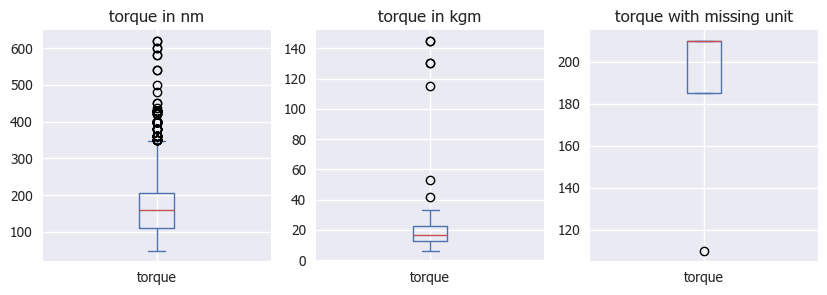


**Investigating outliers in nm:
                                      name               torque  engine  \
2017         Chevrolet Optra Magnum 2.0 LT       305Nm@ 2000rpm  1991.0   
865          Chevrolet Optra Magnum 2.0 LS       305Nm@ 2000rpm  1991.0   
1977     Chevrolet Optra Magnum 2.0 LT BS3       305Nm@ 2000rpm  1991.0   
59        Tata New Safari DICOR 2.2 LX 4x2  320Nm@ 1700-2700rpm  2179.0   
1526       Tata New Safari 3L Dicor LX 4x2  320Nm@ 1700-2700rpm  2956.0   
...                                    ...                  ...     ...   
254                Audi Q5 3.0 TDI Quattro  580Nm@ 1400-3250rpm  2967.0   
1741                      Jaguar XF Diesel       600Nm@ 2000rpm  2993.0   
1171  Jaguar XF 3.0 Litre S Premium Luxury       600Nm@ 2000rpm  2993.0   
882       Mercedes-Benz M-Class ML 350 CDI  619Nm@ 1600-2400rpm  2987.0   
1423                 BMW X7 xDrive 30d DPE  620Nm@ 1500-2500rpm  2993.0   

        mileage  
2017  19.903614  
865   19.903614  
1977  19.903

In [323]:
print("***Visual inspection:")
fig, (ax, ax1, ax2) = plt.subplots(1,3,figsize=(10,3))

torque_val[torque_unit == "nm"].plot(kind="box", ax=ax)
ax.set_title("torque in nm")
ax.set_xlabel("")

torque_val[torque_unit == "kgm"].plot(kind="box", ax=ax1)
ax1.set_title("torque in kgm")

torque_val[pd.isna(torque_unit) == True].plot(kind="box", ax=ax2)
ax2.set_title("torque with missing unit")

plt.show()
plt.close("all")


print("\n**Investigating outliers in nm:")
location = torque_val[(torque_val > 300) & (torque_unit=="nm")].sort_values().index
print(test[["name", "torque", "engine", "mileage"]].iloc[location]) #Comment: Nothing errornous here
 

print("\n**Investigating outliers in kgm:")
location = torque_val[(torque_val > 60) & (torque_unit=="kgm")].sort_values().index
test[["name", "torque", "engine", "mileage"]].iloc[location].pipe(print)


print("\n**Investigating torque with missing units:")
location = torque_val[pd.isna(torque_unit) == True].dropna().sort_values().index
test[["name", "torque", "engine", "mileage"]].iloc[location].pipe(print)

In [324]:
print("***Convert all missing unit obs to nm:")
for i in range(len(torque_val)):
    if pd.isna(torque_unit[i])==True:
        torque_unit[i] = "nm"

print("\n**With torque in kgm: Change torque_unit of all obs >= 100")
for i in range(len(torque_val)):
    if( (pd.isna(torque_val[i])==False) & (torque_unit[i]=="kgm") & (torque_val[i]>=100)):
        torque_unit[i] = "nm"

***Convert all missing unit obs to nm:

**With torque in kgm: Change torque_unit of all obs >= 100


In [325]:
print("***Convert to nm:")

for i in range(len(torque_val)):
    if torque_unit[i] == "kgm":
        torque_unit[i] = "nm"
        torque_val[i] = torque_val[i]/0.102
        
torque_val.info()
torque_unit.unique()

***Convert to nm:
<class 'pandas.core.series.Series'>
RangeIndex: 2128 entries, 0 to 2127
Series name: torque
Non-Null Count  Dtype  
--------------  -----  
2066 non-null   float64
dtypes: float64(1)
memory usage: 16.8 KB


array(['nm'], dtype=object)

In [326]:
test["torque"] = torque_val

## <span style="color:darkblue; font-weight:bold"> E.Export cleaned data </span>

In [327]:
train.info()
train = train.drop(["name"], axis=1)
train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6000 non-null   object 
 1   year           6000 non-null   int64  
 2   selling_price  6000 non-null   int64  
 3   km_driven      6000 non-null   int64  
 4   fuel           6000 non-null   object 
 5   seller_type    6000 non-null   object 
 6   transmission   6000 non-null   object 
 7   owner          6000 non-null   object 
 8   mileage        5828 non-null   float64
 9   engine         5841 non-null   float64
 10  max_power      5840 non-null   float64
 11  torque         5840 non-null   float64
 12  seats          5841 non-null   float64
 13  brand          6000 non-null   object 
dtypes: float64(5), int64(3), object(6)
memory usage: 656.4+ KB


,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand
0,2018,850000,9500,Diesel,Individual,Manual,First Owner,25.903614,1497.0,108.50,260.00,5.0,Tata
1,2018,750000,30000,Diesel,Individual,Manual,First Owner,25.530120,1396.0,88.76,219.66,5.0,Hyundai
2,2015,1500000,80000,Diesel,Individual,Automatic,Second Owner,15.120482,2982.0,168.50,360.00,7.0,Toyota
3,2015,795000,35000,Petrol,Individual,Manual,First Owner,22.986486,1591.0,121.30,154.90,5.0,Hyundai
4,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,21.686747,1969.0,190.00,400.00,5.0,Volvo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2010,235000,50000,Petrol,Individual,Manual,First Owner,25.675676,998.0,66.10,90.00,5.0,Maruti
5996,2018,390000,40000,CNG,Individual,Manual,First Owner,26.600000,998.0,58.16,77.00,5.0,Maruti
5997,2018,450000,75000,Petrol,Individual,Manual,First Owner,27.432432,1199.0,84.00,114.00,5.0,Tata
5998,2011,250000,100000,Diesel,Individual,Manual,Second Owner,19.228916,2523.0,63.00,180.00,9.0,Mahindra


In [328]:
test.info()
test = test.drop(["name", "id"], axis=1)
test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            2128 non-null   int64  
 1   name          2128 non-null   object 
 2   year          2128 non-null   int64  
 3   km_driven     2128 non-null   int64  
 4   fuel          2128 non-null   object 
 5   seller_type   2128 non-null   object 
 6   transmission  2128 non-null   object 
 7   owner         2128 non-null   object 
 8   mileage       2066 non-null   float64
 9   engine        2066 non-null   float64
 10  max_power     2067 non-null   float64
 11  torque        2066 non-null   float64
 12  seats         2066 non-null   float64
 13  brand         2128 non-null   object 
dtypes: float64(5), int64(3), object(6)
memory usage: 232.9+ KB


,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,brand
0,2016,11000,Petrol,Dealer,Automatic,First Owner,19.324324,1598.0,103.50,153.00,5.0,Skoda
1,2017,35000,Petrol,Individual,Manual,First Owner,24.054054,1497.0,117.30,145.00,5.0,Honda
2,2014,80000,Petrol,Individual,Manual,First Owner,25.810811,1197.0,82.00,114.00,5.0,Hyundai
3,2014,145241,Diesel,Individual,Manual,First Owner,14.518072,2179.0,120.00,290.00,7.0,Mahindra
4,2015,92651,Diesel,Dealer,Manual,First Owner,26.144578,1498.0,98.96,215.00,5.0,Ford
...,...,...,...,...,...,...,...,...,...,...,...,...
2123,2020,2000,Petrol,Dealer,Manual,First Owner,27.972973,1197.0,81.86,113.75,5.0,Hyundai
2124,2018,100000,Diesel,Individual,Manual,Second Owner,34.216867,1248.0,74.02,190.00,5.0,Maruti
2125,2011,172000,Diesel,Individual,Manual,Second Owner,21.542169,1396.0,52.80,85.00,5.0,Tata
2126,2017,47000,Diesel,Individual,Manual,Second Owner,23.698795,1582.0,126.20,259.90,5.0,Hyundai


In [329]:
train.to_csv('cleaned_train.csv', index=False)
test.to_csv('cleaned_test.csv', index=False)